In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Normalize and reshape data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [4]:
# Add Gaussian noise to the images
noise_factor = 0.5
x_train_gaussian_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_gaussian_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_gaussian_noisy = np.clip(x_train_gaussian_noisy, 0., 1.)
x_test_gaussian_noisy = np.clip(x_test_gaussian_noisy, 0., 1.)

In [5]:
# Add Salt and Pepper noise to the images
noise_factor = 0.5
img_size = x_test[0].size
noise_size = int(noise_factor * img_size)

x_train_saltpepper_noisy = x_train.copy()
x_test_saltpepper_noisy = x_test.copy()

for i in range(x_train.shape[0]):
  random_indices = np.random.choice(img_size, noise_size)
  noise = np.random.choice([0., 1.], noise_size)
  x_train_saltpepper_noisy[i].flat[random_indices] = noise

for i in range(x_test.shape[0]):
  random_indices = np.random.choice(img_size, noise_size)
  noise = np.random.choice([0., 1.], noise_size)
  x_test_saltpepper_noisy[i].flat[random_indices] = noise

In [6]:
# Add Speckle Noise to the images
noise_factor = 0.5

x_train_speckle_noisy = x_train.copy()
x_test_speckle_noisy = x_test.copy()
for i in range(x_train.shape[0]):
  x_train_speckle_noisy[i] = x_train_speckle_noisy[i] + noise_factor * np.random.rand(28, 28, 1)
  x_train_speckle_noisy[i] = np.clip(x_train_speckle_noisy[i], 0., 1.)

for i in range(x_test.shape[0]):
  x_test_speckle_noisy[i] = x_test_speckle_noisy[i] + noise_factor * np.random.rand(28, 28, 1)
  x_test_speckle_noisy[i] = np.clip(x_test_speckle_noisy[i], 0., 1.)

In [7]:
# Add Poisson Noise to the images
x_train_poisson_noisy = np.random.poisson(x_train)
x_test_poisson_noisy = np.random.poisson(x_test)
x_train_poisson_noisy = x_train_poisson_noisy.astype('float32')
x_test_poisson_noisy = x_test_poisson_noisy.astype('float32')

In [8]:
def build_unet_model():
  input_shape = (28, 28, 1)

  # Define the input tensor
  inputs = tf.keras.layers.Input(input_shape)

  # Define the encoder part of the network
  conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

  conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

  conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

  # Define the decoder part of the network
  up4 = tf.keras.layers.UpSampling2D((2, 2))(conv3)
  up4 = tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='same')(up4)
  merge4 = tf.keras.layers.concatenate([conv2, up4], axis=3)

  conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
  conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

  up5 = tf.keras.layers.UpSampling2D((2, 2))(conv4)
  up5 = tf.keras.layers.Conv2D(32, (2, 2), activation='relu', padding='same')(up5)
  merge5 = tf.keras.layers.concatenate([conv1, up5], axis=3)

  conv5 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge5)
  conv5 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

  # Define the output layer of the network
  output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)

  # Define the model
  model = tf.keras.models.Model(inputs=[inputs], outputs=[output])
  return model

In [9]:
# Compile and train model
unet_model = build_unet_model()
unet_model.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 28, 28, 32)     │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 14, 14, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 7, 7, 64)       │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 7, 7, 128)      │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 14, 14, 128)    │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 14, 14, 64)     │         32,832 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 14, 14, 128)    │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 14, 14, 64)     │         73,792 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 64)     │         36,928 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 28, 28, 64)     │              0 │ conv2d_8[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 28, 28, 32)     │          8,224 │ up_sampling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 28, 28, 64)     │              0 │ conv2d_1[0][0],        │
│ (Concatenate)        

 Total params: 465,953 (1.78 MB)

 Trainable params: 465,953 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the network with one of the noisy images

# x_train_noisy = x_train_poisson_noisy
# x_test_noisy = x_test_poisson_noisy

# x_train_noisy = x_train_gaussian_noisy
# x_test_noisy = x_test_gaussian_noisy

# x_train_noisy = x_train_saltpepper_noisy
# x_test_noisy = x_test_saltpepper_noisy

x_train_noisy = x_train_speckle_noisy
x_test_noisy = x_test_speckle_noisy

In [12]:
history = unet_model.fit(x_train_noisy, x_train, epochs=20, batch_size=128,
                         validation_data=(x_test_noisy, x_test), callbacks=[EarlyStopping(patience=10)])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - loss: 0.1837 - val_loss: 0.0674
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.0677 - val_loss: 0.0662
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0665 - val_loss: 0.0656
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0658 - val_loss: 0.0655
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0656 - val_loss: 0.0651
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0654 - val_loss: 0.0650
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.0653 - val_loss: 0.0652
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0650 - val_loss: 0.0647
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0651 - val_loss: 0.0647
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0650 - val_loss: 0.0646
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0649 - val_loss: 0.0645
Epoch 12/20
469/469 ━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

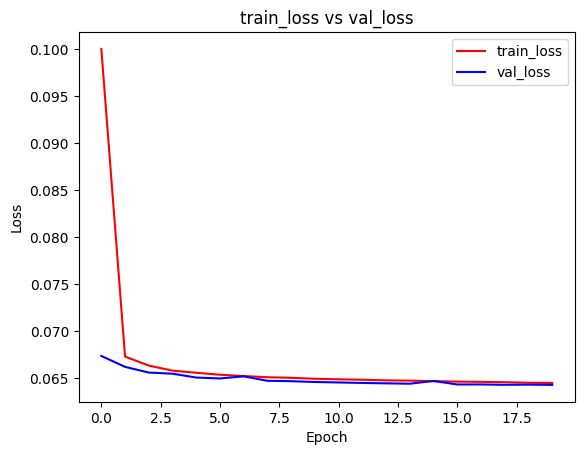

<Figure size 640x480 with 0 Axes>

In [13]:
epochs = range(len(history.history['loss']))

plt.plot(epochs,history.history['loss'],'r', label='train_loss')
plt.plot(epochs,history.history['val_loss'],'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

In [14]:
def psnr(y_true, y_pred, max_val=1.0):
  """Computes the peak signal-to-noise ratio (PSNR) between two images.

  Args:
    y_true: The ground truth image tensor.
    y_pred: The predicted image tensor.
    max_val: The maximum pixel value in the images.

  Returns:
    The PSNR value as a scalar tensor.
  """

  mse = tf.reduce_mean(tf.square(y_true - y_pred))
  psnr_value = 20 * tf.math.log(max_val / tf.sqrt(mse)) / tf.math.log(10.0)
  return psnr_value

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


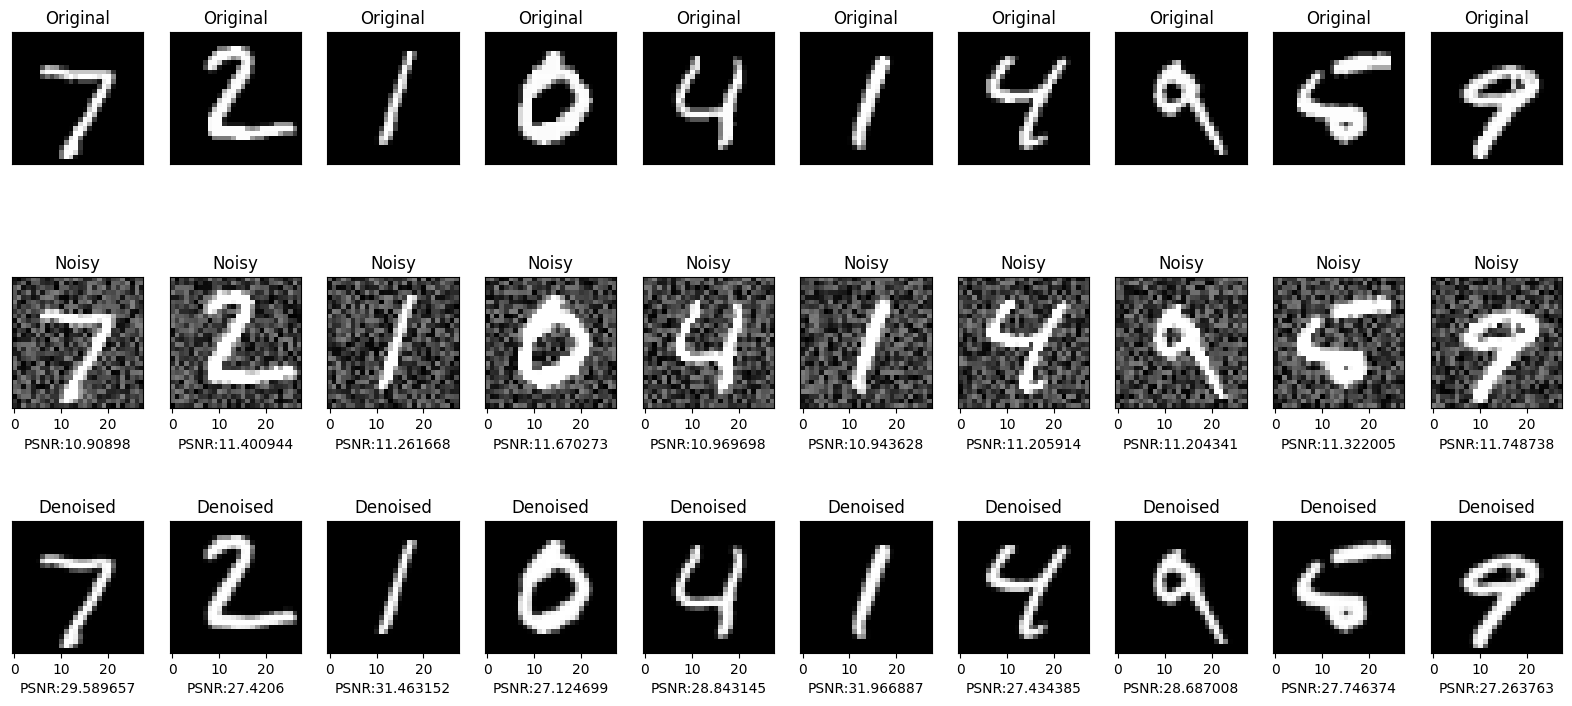

In [15]:
denoised_test_images = unet_model.predict(x_test_noisy)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 9))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    diff = psnr(x_test[i], x_test_noisy[i].astype('float32'))
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    diff = psnr(x_test[i], denoised_test_images[i])
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

plt.show()

In [16]:
# Compute the PSNR of each denoised image with the original test image
# Accumulate the PSNR of all the denoised images and print the accumulated sum
total_psnr = 0.0
for i in range(x_test_noisy.shape[0]):
  diff = psnr(x_test[i], denoised_test_images[i])
  total_psnr += tf.get_static_value(diff)

print('Total PSNR : ', total_psnr)

Total PSNR :  287076.1500854492


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


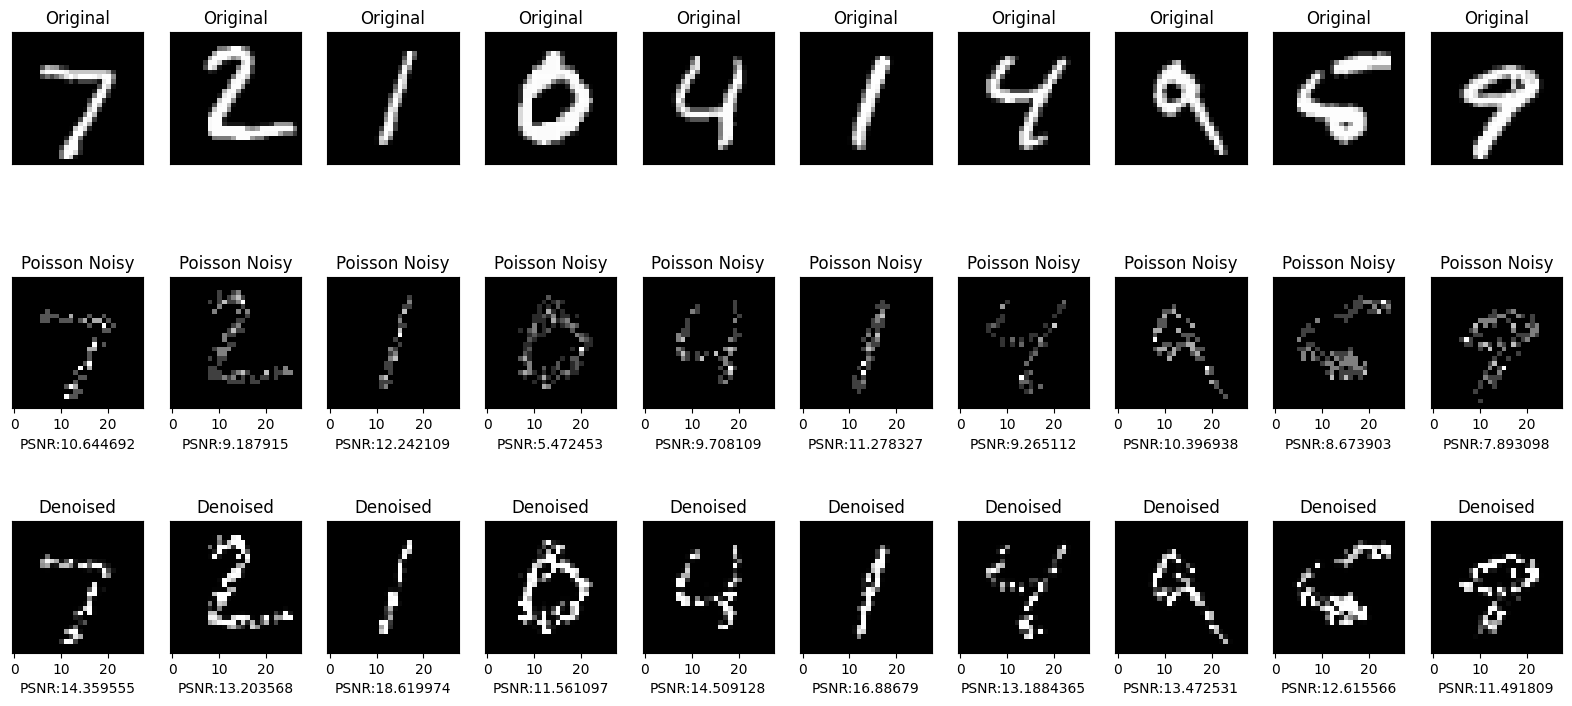

In [17]:
# Train with some noisy images but try denoising another set of noisy images
noisy_images = x_test_poisson_noisy
denoised_test_images = unet_model.predict(noisy_images)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 9))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Poisson Noisy")
    diff = psnr(x_test[i], noisy_images[i].astype('float32'))
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    diff = psnr(x_test[i], denoised_test_images[i])
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

plt.show()

In [18]:
# Train with some noisy images but try denoising another set of noisy images
# Compute PSNR with the denoising of another noise image
total_psnr = 0.0
for i in range(x_test_noisy.shape[0]):
  diff = psnr(x_test[i], denoised_test_images[i])
  total_psnr += tf.get_static_value(diff)

print('Total PSNR : ', total_psnr)

Total PSNR :  132206.23666000366


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


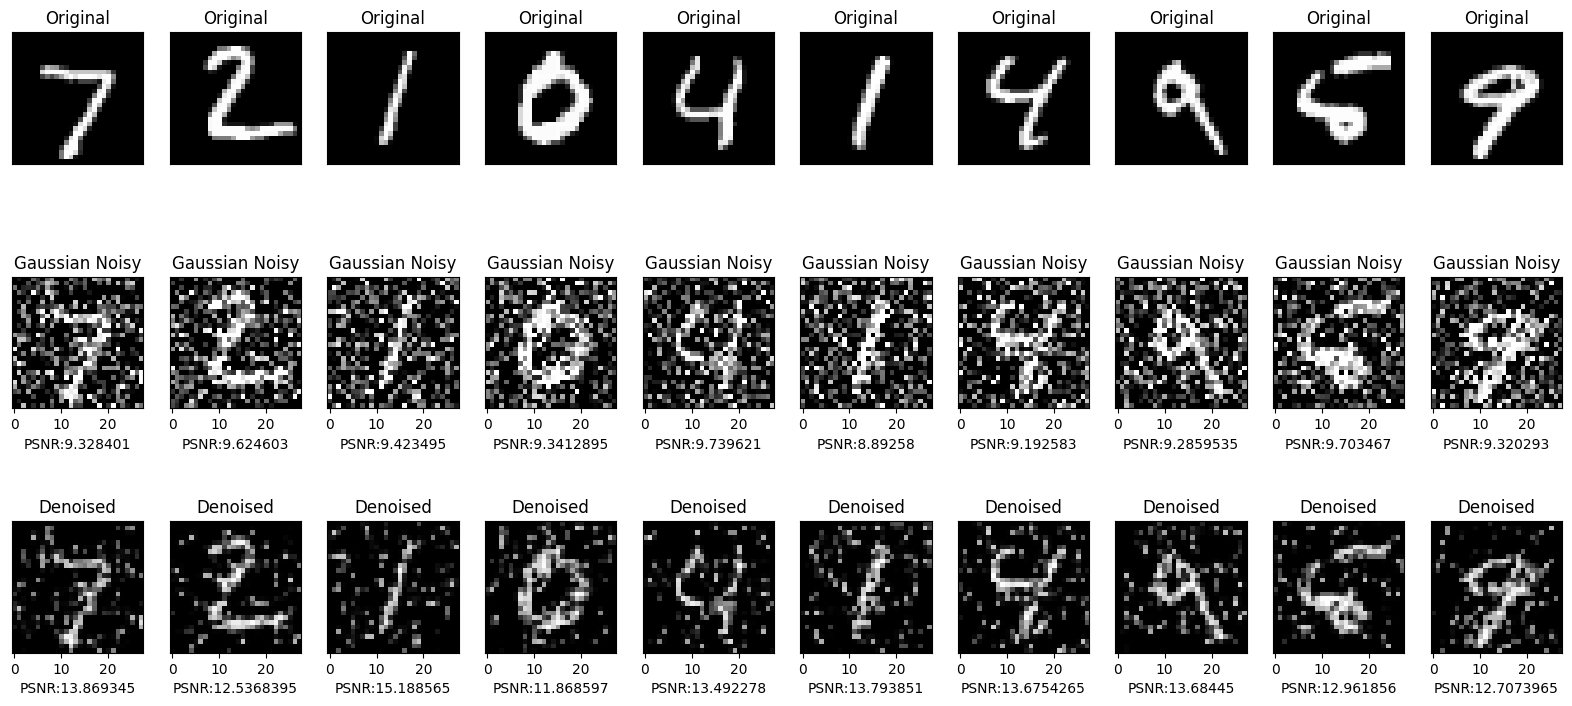

In [20]:
# Train with some noisy images but try denoising Gaussian noisy images
noisy_images = x_test_gaussian_noisy
denoised_test_images = unet_model.predict(noisy_images)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 9))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Gaussian Noisy")
    diff = psnr(x_test[i], noisy_images[i].astype('float32'))
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    diff = psnr(x_test[i], denoised_test_images[i])
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

plt.show()

In [21]:
# Train with some noisy images but try denoising another set of noisy images
# Compute PSNR with the denoising of another noise image
total_psnr = 0.0
for i in range(x_test_noisy.shape[0]):
  diff = psnr(x_test[i], denoised_test_images[i])
  total_psnr += tf.get_static_value(diff)

print('Total PSNR : ', total_psnr)

Total PSNR :  131984.80808734894


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


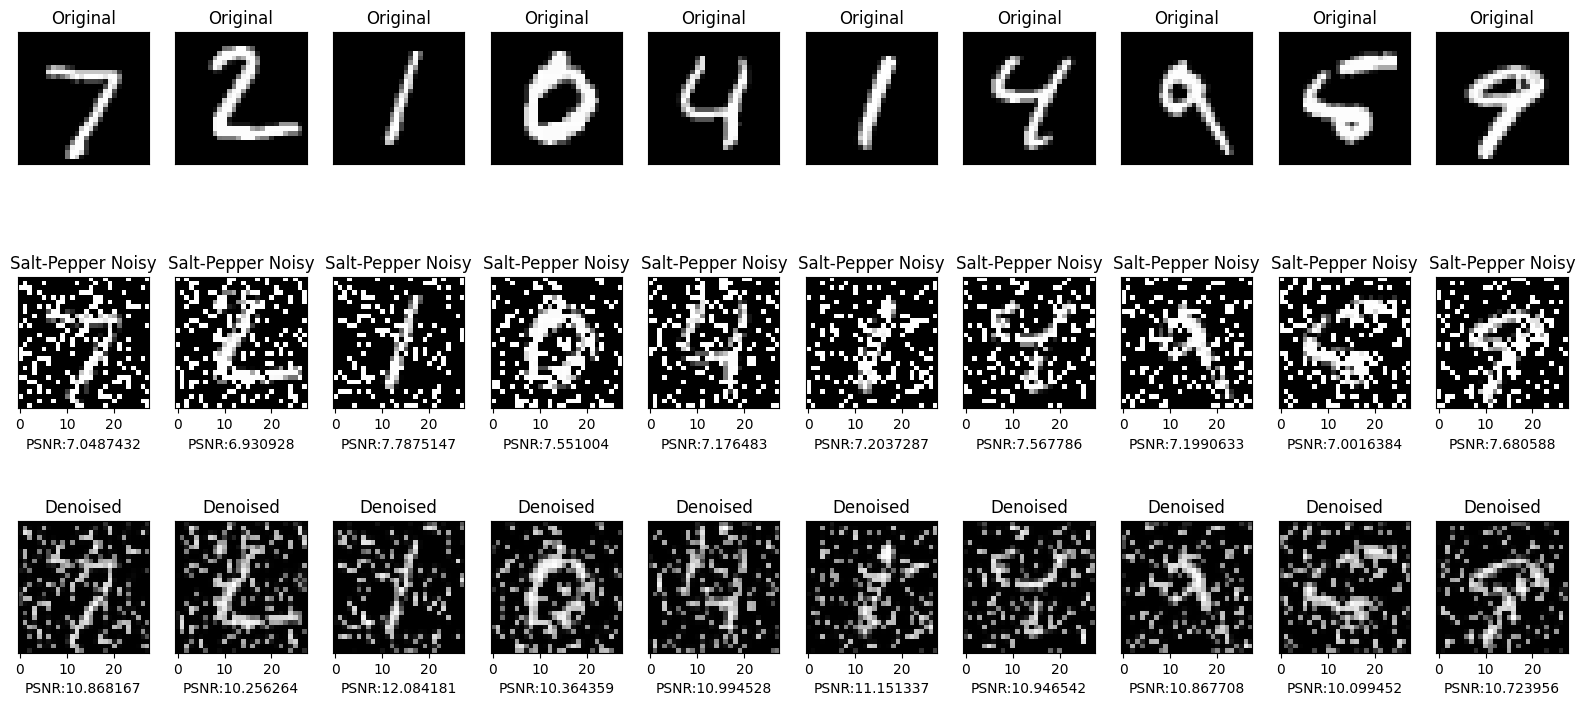

In [22]:
# Train with some noisy images but try denoising Salt-Pepper noisy images
noisy_images = x_test_saltpepper_noisy
denoised_test_images = unet_model.predict(noisy_images)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 9))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Salt-Pepper Noisy")
    diff = psnr(x_test[i], noisy_images[i].astype('float32'))
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    diff = psnr(x_test[i], denoised_test_images[i])
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

plt.show()

In [23]:
# Train with some noisy images but try denoising another set of noisy images
# Compute PSNR with the denoising of another noise image
total_psnr = 0.0
for i in range(x_test_noisy.shape[0]):
  diff = psnr(x_test[i], denoised_test_images[i])
  total_psnr += tf.get_static_value(diff)

print('Total PSNR : ', total_psnr)

Total PSNR :  105568.99078083038


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


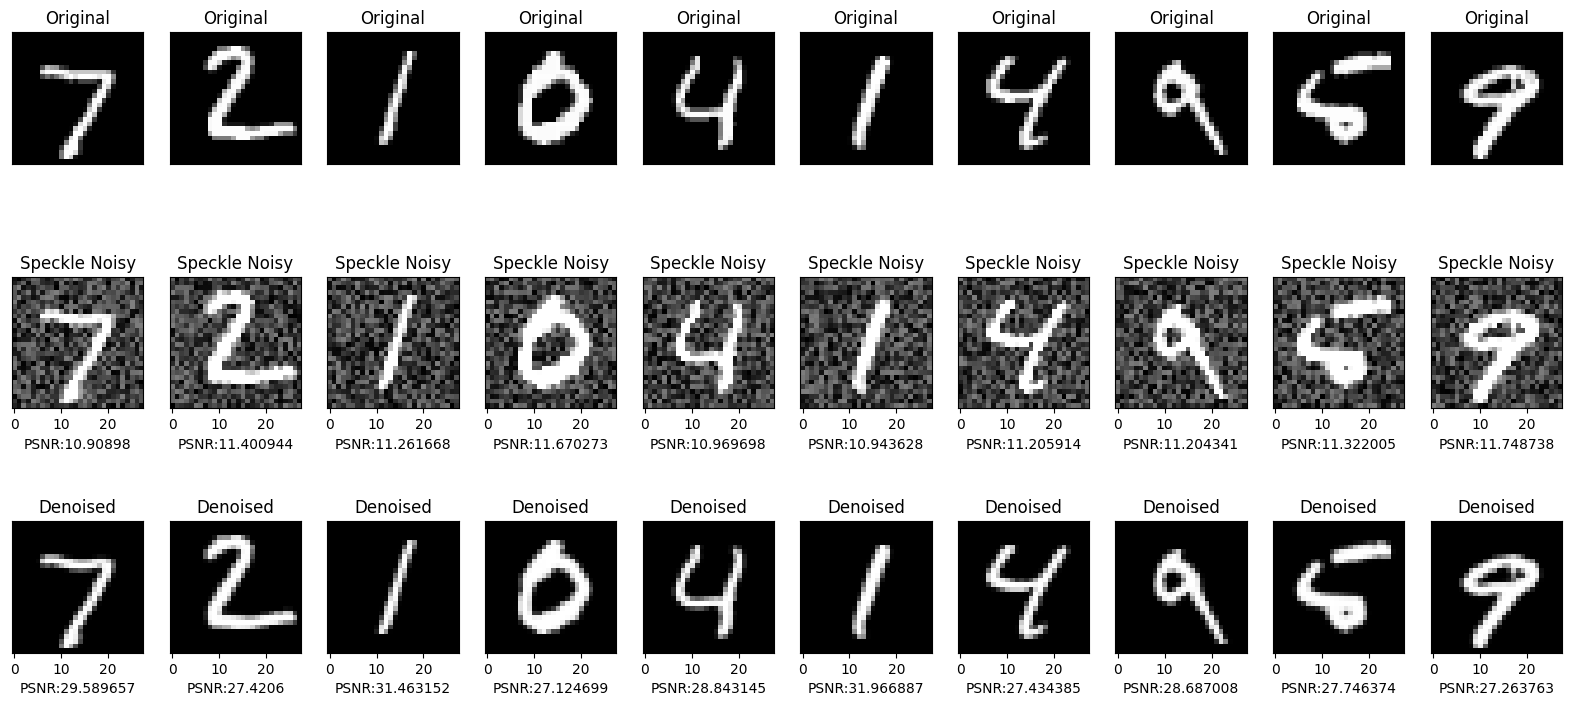

In [24]:
# Train with some noisy images but try denoising Speckle noisy images
noisy_images = x_test_speckle_noisy
denoised_test_images = unet_model.predict(noisy_images)

# Display original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 9))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
    plt.title("Speckle Noisy")
    diff = psnr(x_test[i], noisy_images[i].astype('float32'))
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    diff = psnr(x_test[i], denoised_test_images[i])
    plt.xlabel('PSNR:'+str(tf.get_static_value(diff)))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)

plt.show()

In [25]:
# Train with some noisy images but try denoising another set of noisy images
# Compute PSNR with the denoising of another noise image
total_psnr = 0.0
for i in range(x_test_noisy.shape[0]):
  diff = psnr(x_test[i], denoised_test_images[i])
  total_psnr += tf.get_static_value(diff)

print('Total PSNR : ', total_psnr)

Total PSNR :  287076.1500854492
